In [1]:
import sys
import os

# Get the absolute path of the parent directory.
parent_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))

# Add the parent directory to the system path to be able to import modules from 'lib.'
sys.path.append(parent_dir)

In [2]:
from IPython.display import HTML, Markdown as md
import itertools

from lib.memory import DSDM
from lib.utils import configs, inference, learning, preprocess, utils 

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy
import numpy as np
import random

import pandas as pd
import pathlib

import seaborn as sns

from transformers import AutoTokenizer, AutoModel

import torch
import torchhd as thd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F 

from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     /nfs/home/dfichiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /nfs/home/dfichiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
model_name = "bert-base-uncased"  # Has 12 layers
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [4]:
text = "Dagored is an Italian record labels based in Firenze formed in 1998."
inputs = tokenizer(text, return_tensors="pt")

In [5]:
outputs = model(**inputs, output_attentions=True)
attention_matrix = outputs.attentions

In [6]:
encoding = tokenizer.encode(text)
labels = tokenizer.convert_ids_to_tokens(encoding)

In [7]:
encoding

[101,
 4830,
 20255,
 2098,
 2003,
 2019,
 3059,
 2501,
 10873,
 2241,
 1999,
 2543,
 14191,
 2063,
 2719,
 1999,
 2687,
 1012,
 102]

In [8]:
pd.DataFrame(labels, columns=['token']).head(20)

,token
0,[CLS]
1,da
2,##gor
3,##ed
4,is
5,an
6,italian
7,record
8,labels
9,based


In [9]:
#attention_matrix[0].shape # Layer

In [10]:
#attention_matrix[0][0].shape # Attention heads, Token-Token matrices

In [11]:
# token = 0

# token_scores = attention_matrix[0][0][0][token].cpu().detach().numpy() # First token

In [12]:
attention_matrix[11][0].shape

torch.Size([12, 19, 19])

In [13]:
attention_matrix[11].shape

torch.Size([1, 12, 19, 19])

In [14]:
#len(attention_matrix[0][0][head].cpu().detach().numpy()[0])

NameError: name 'head' is not defined

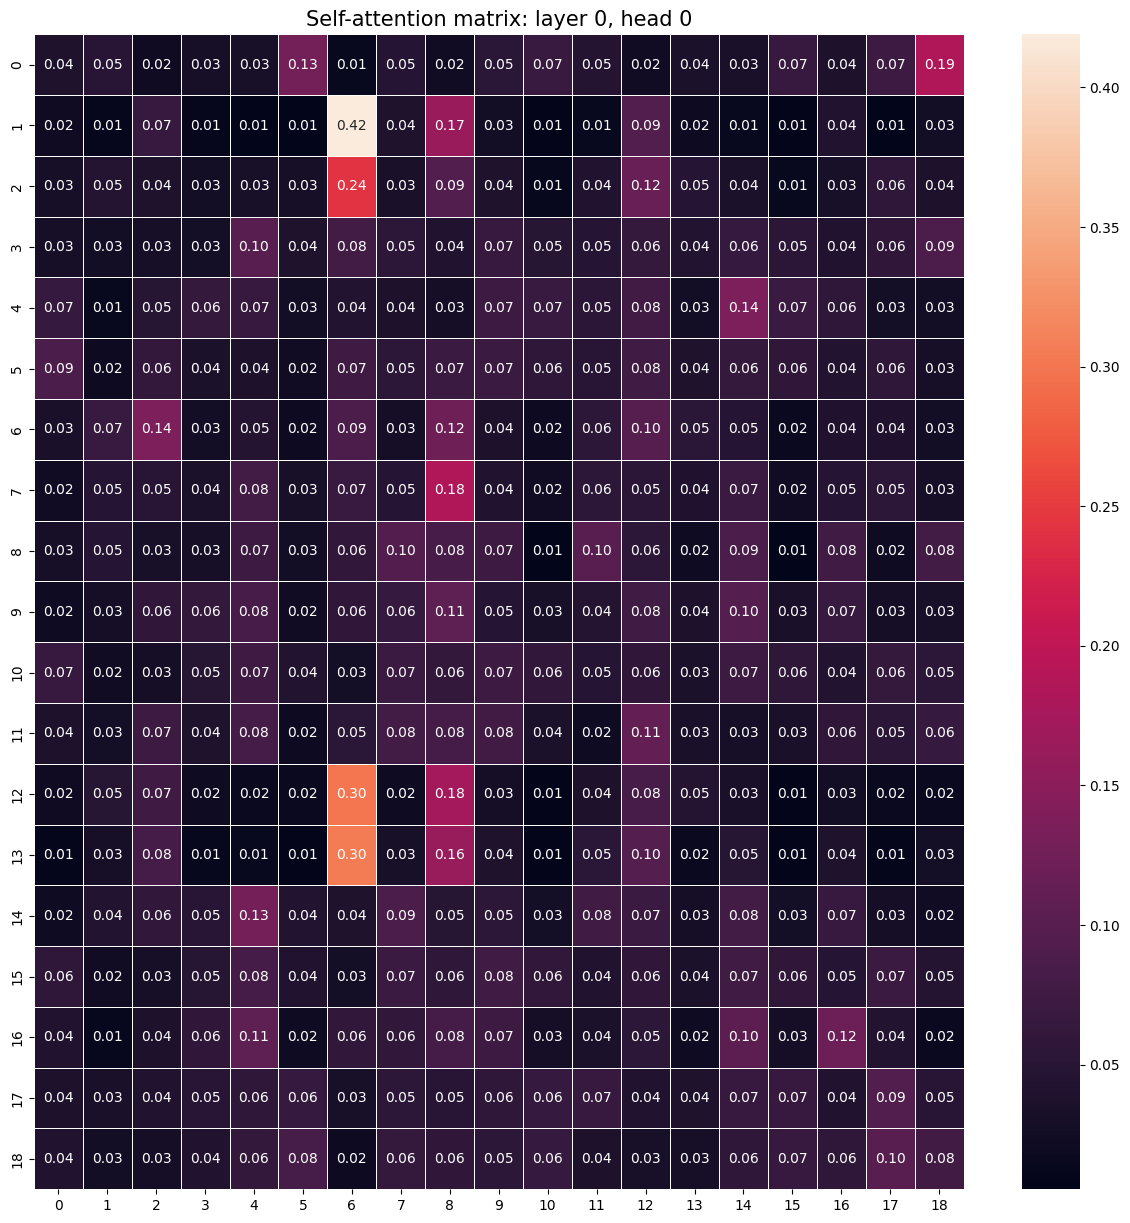

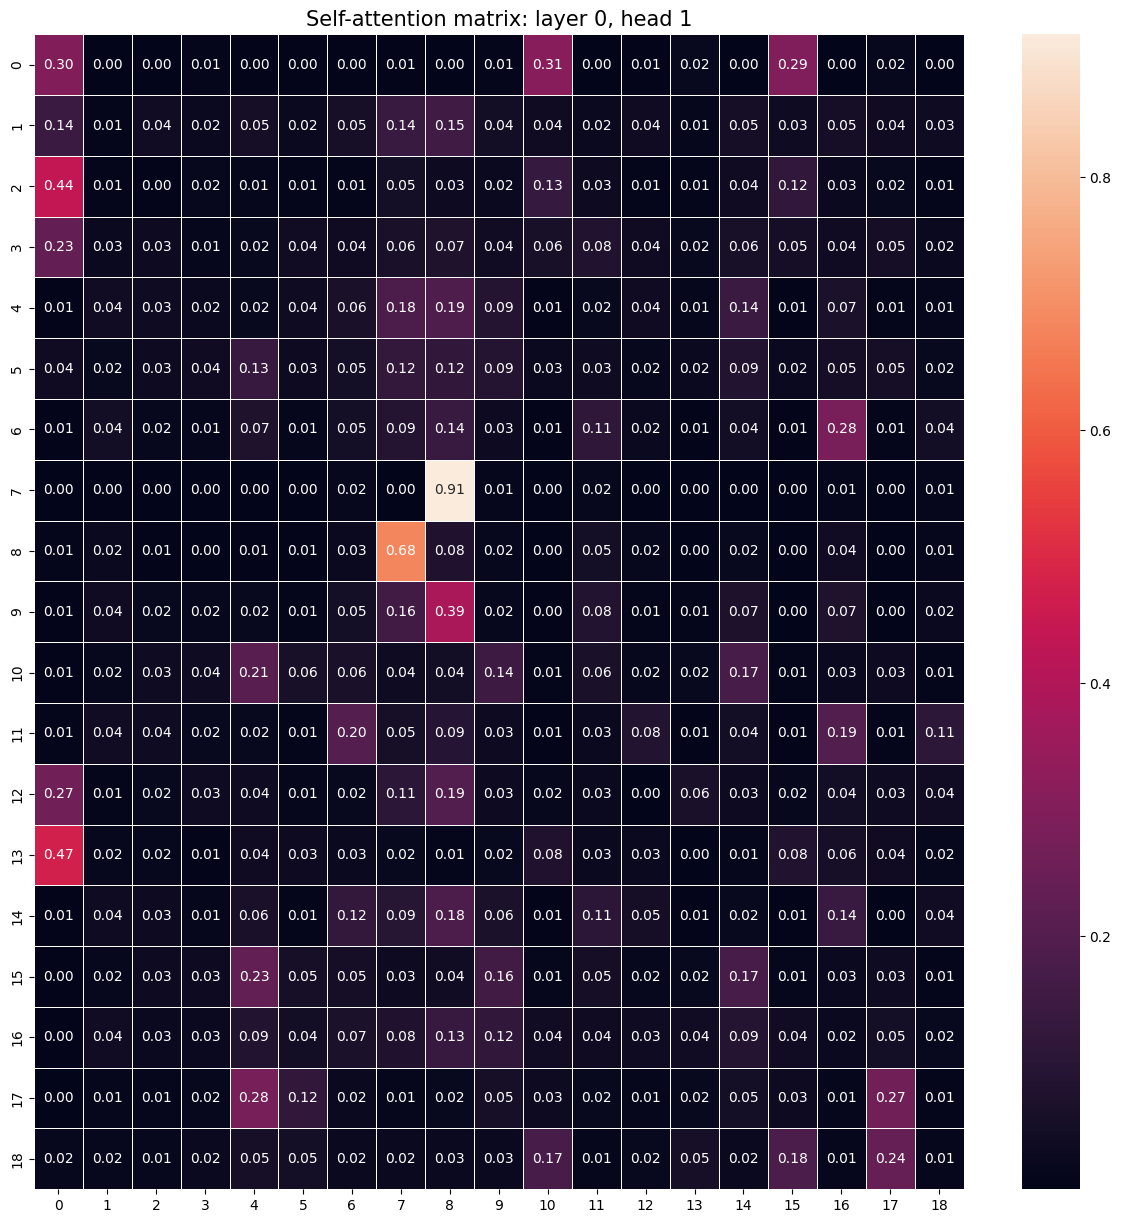

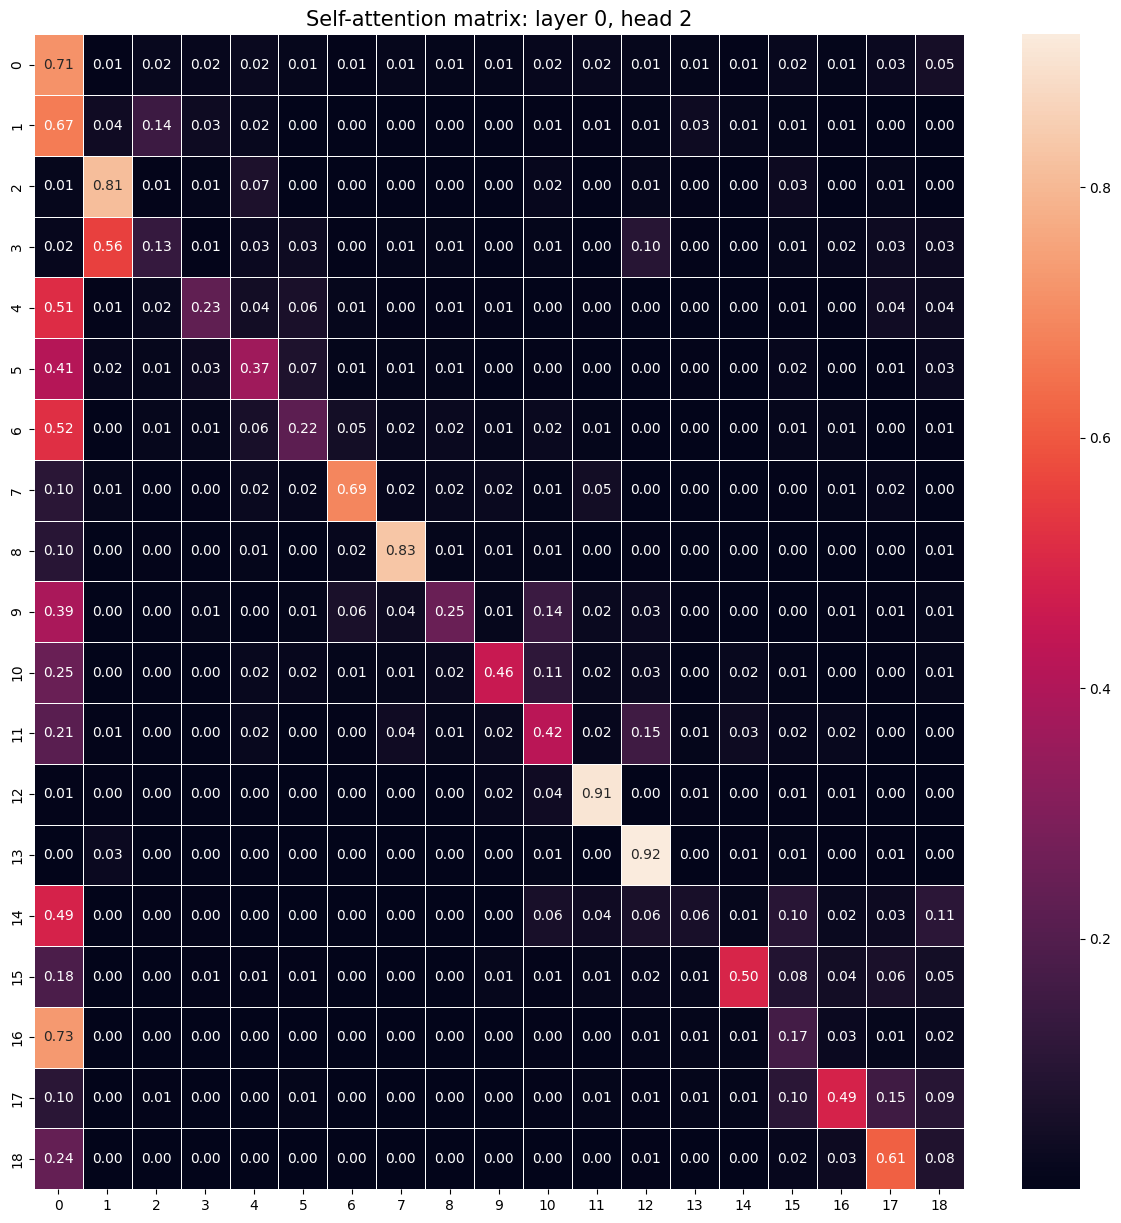

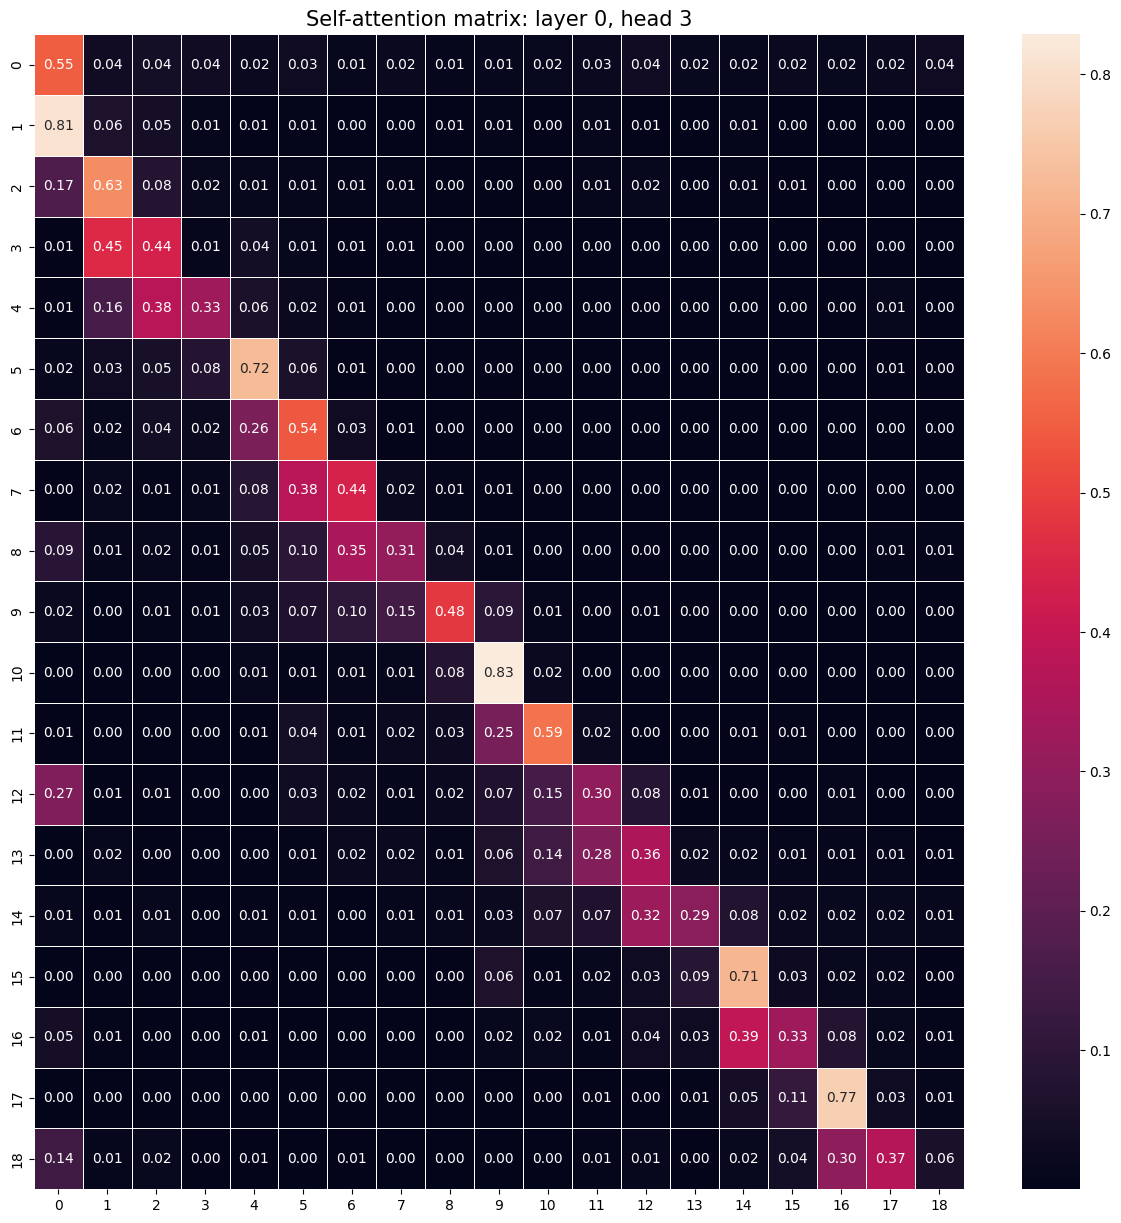

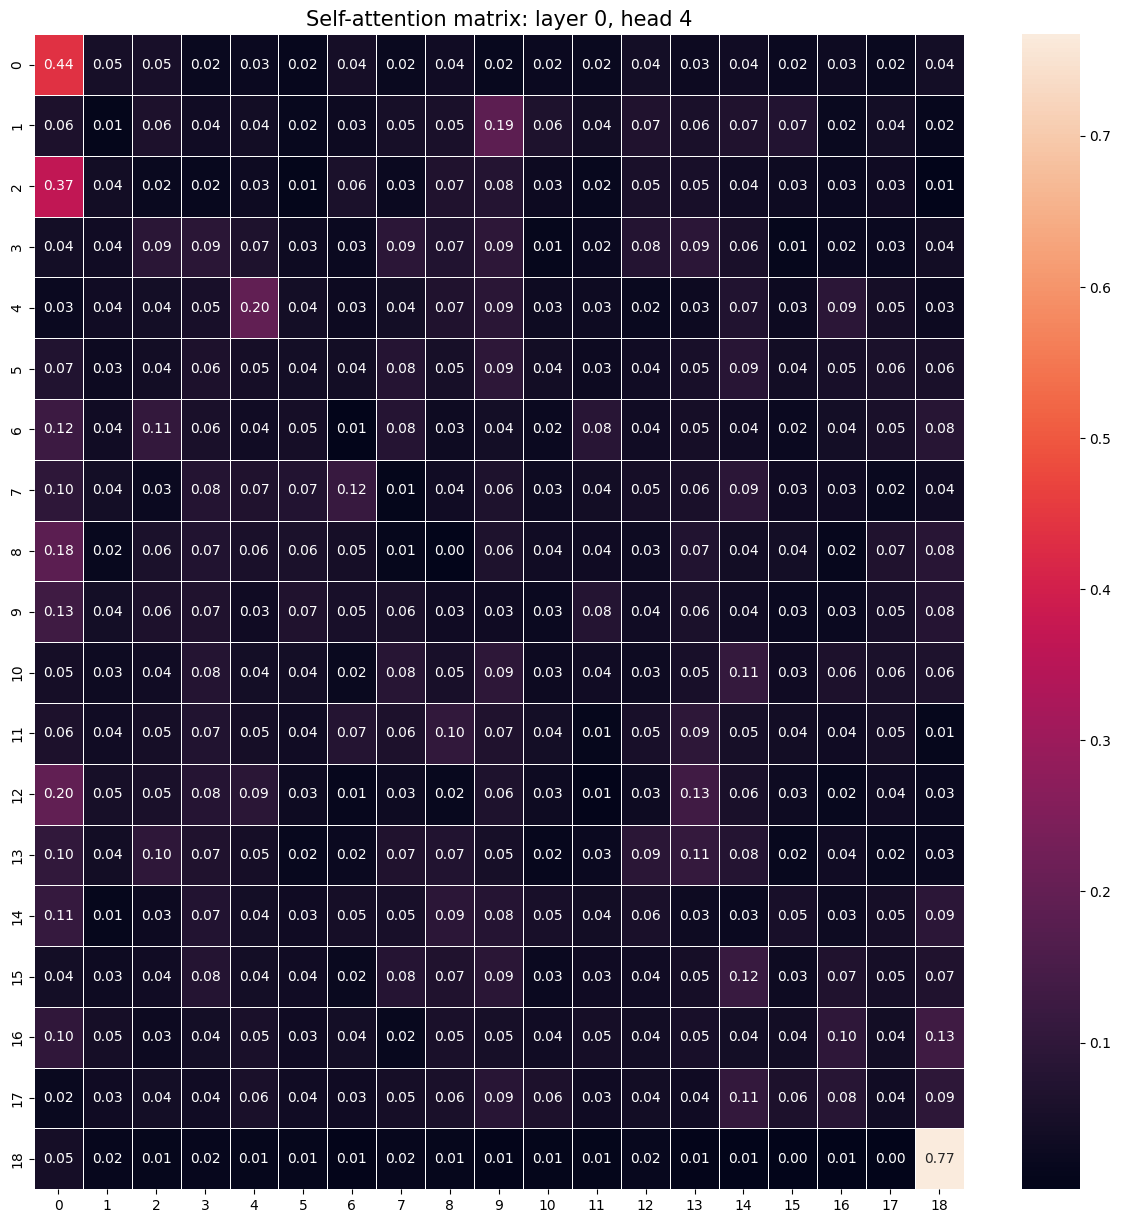

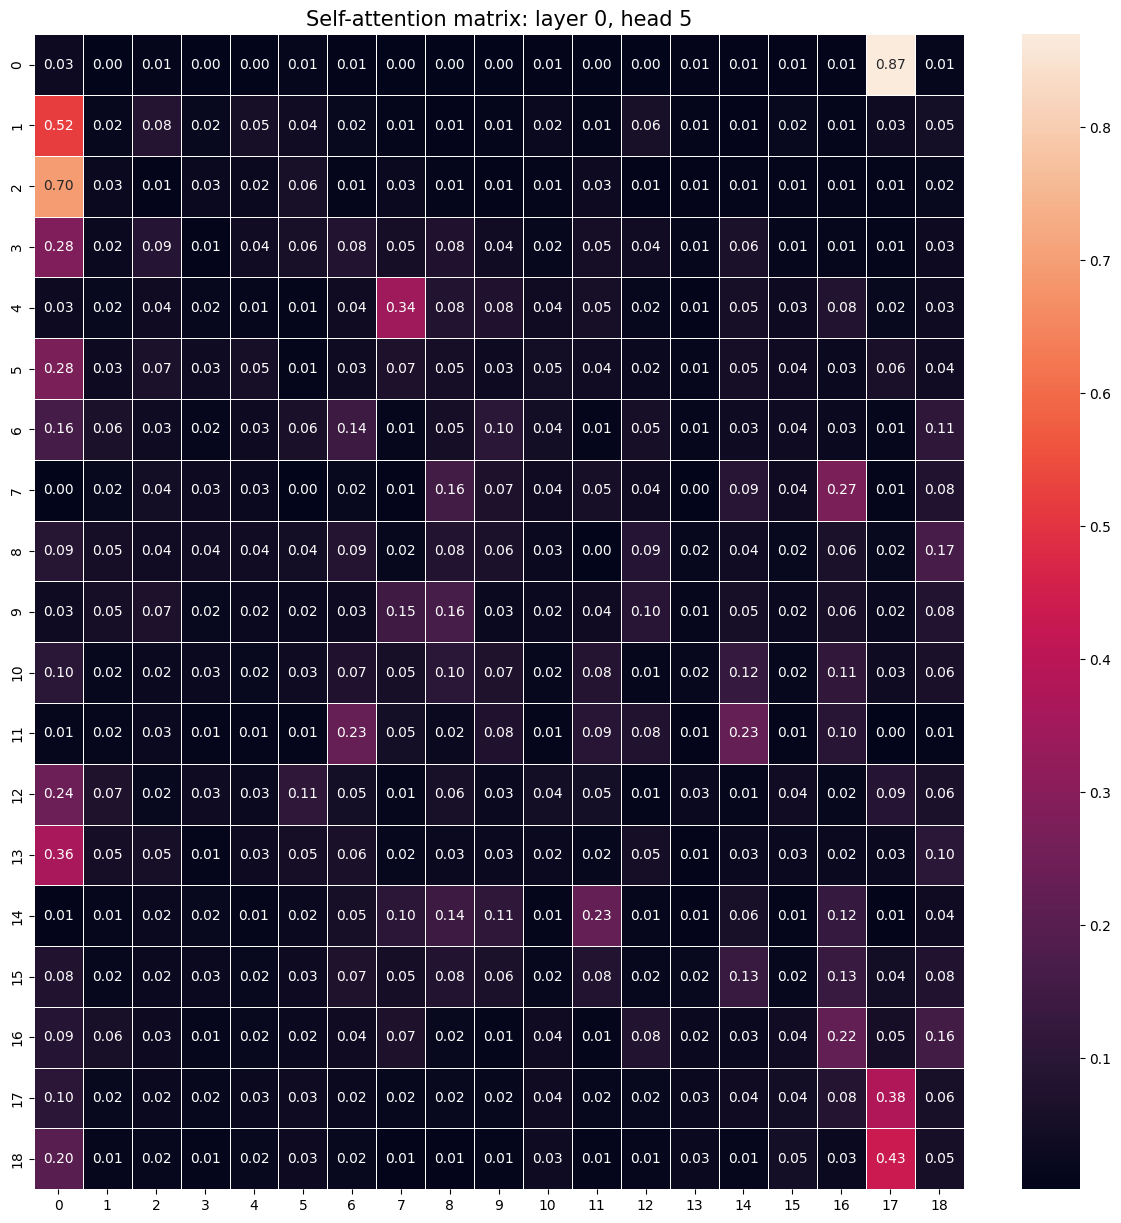

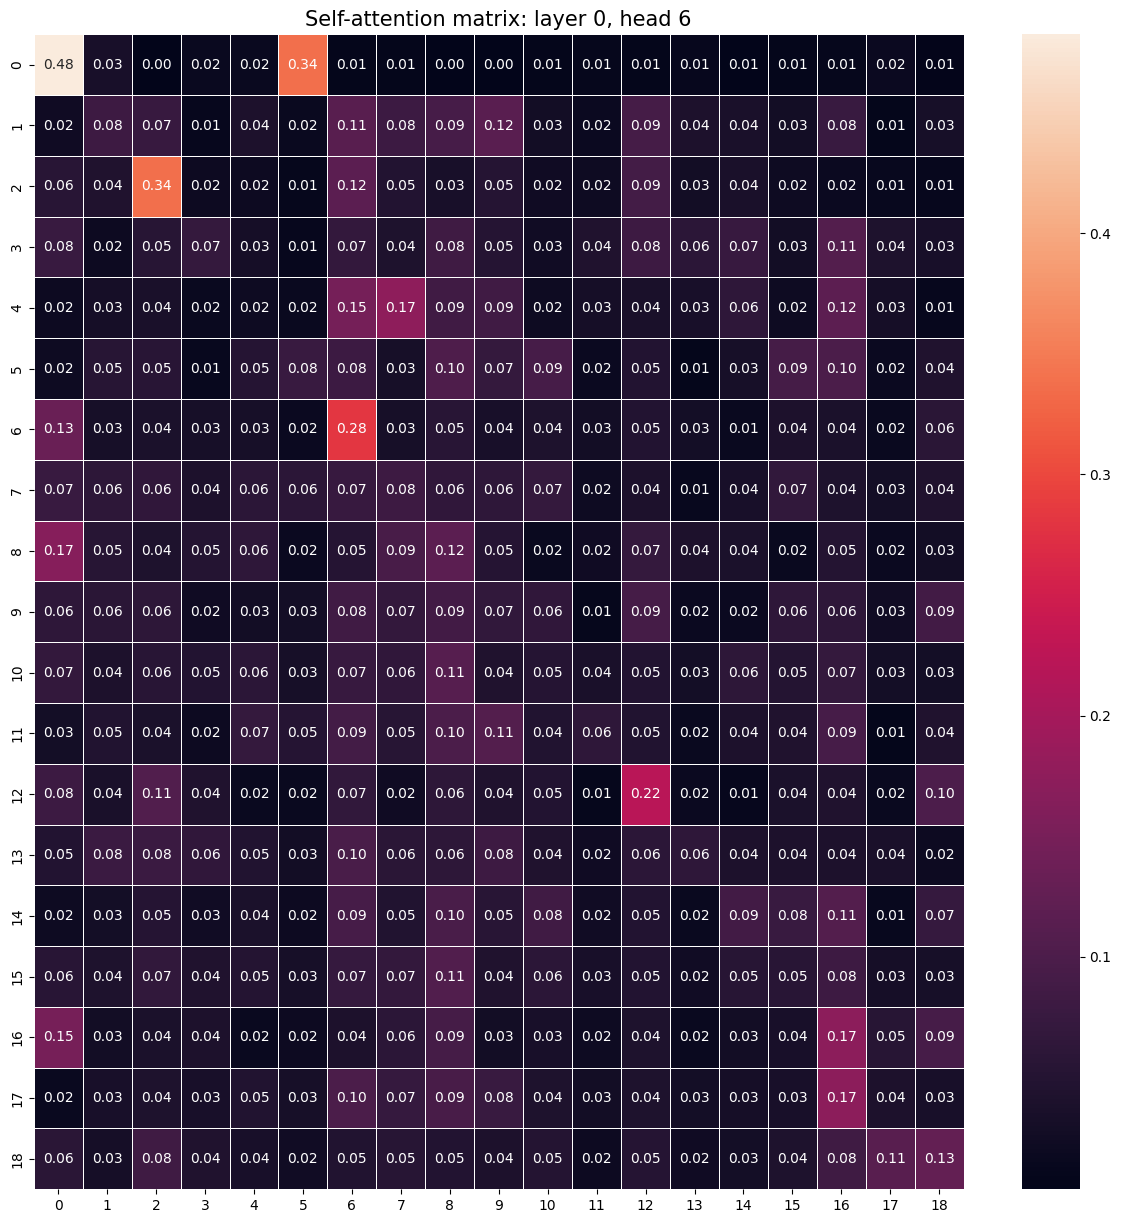

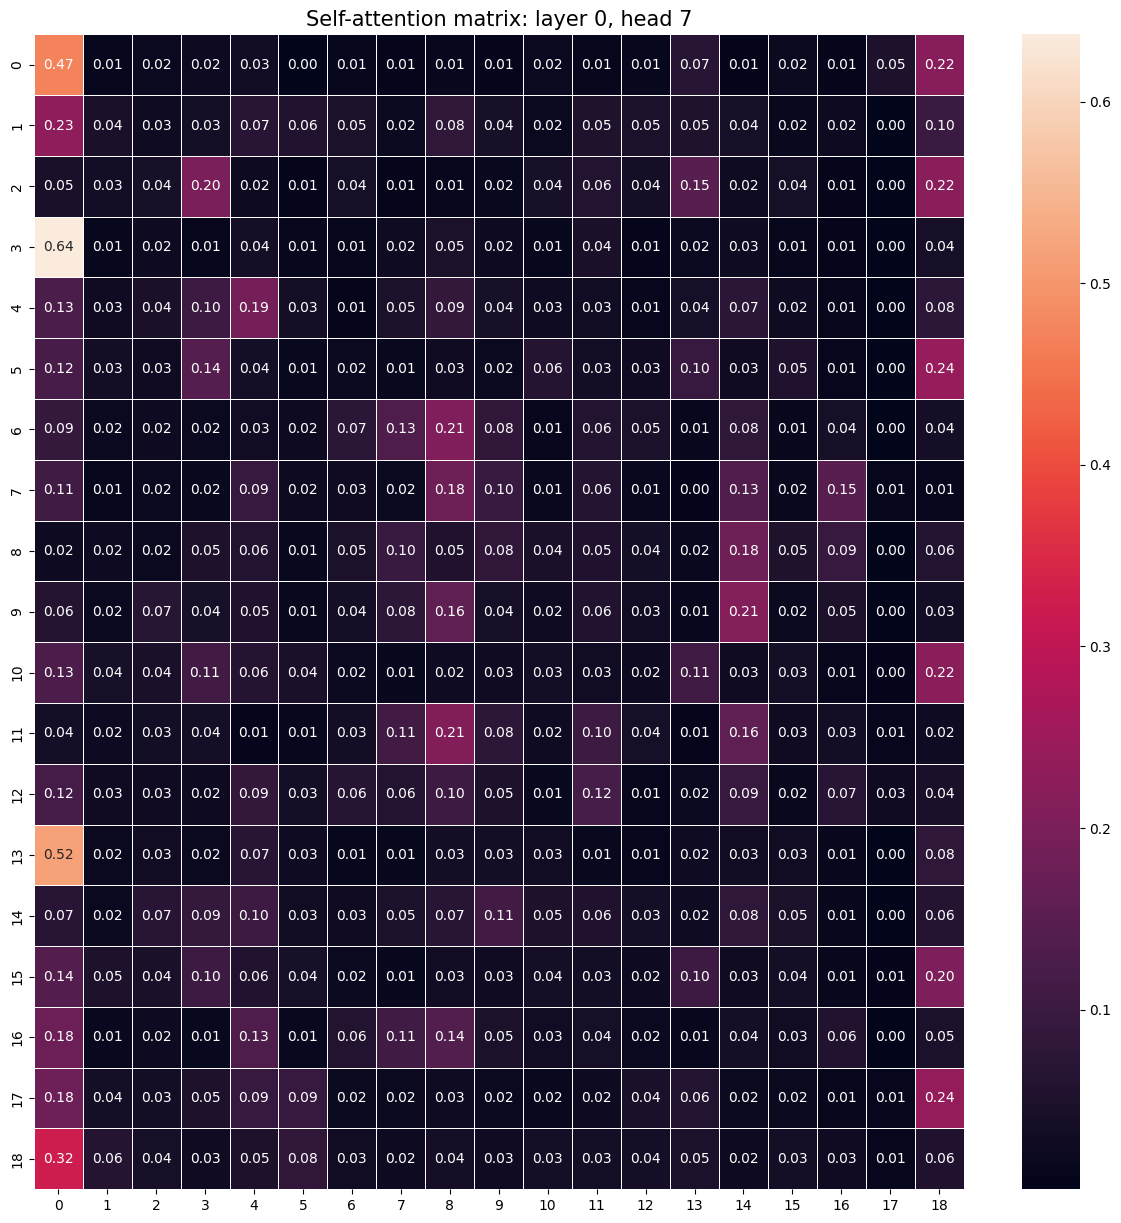

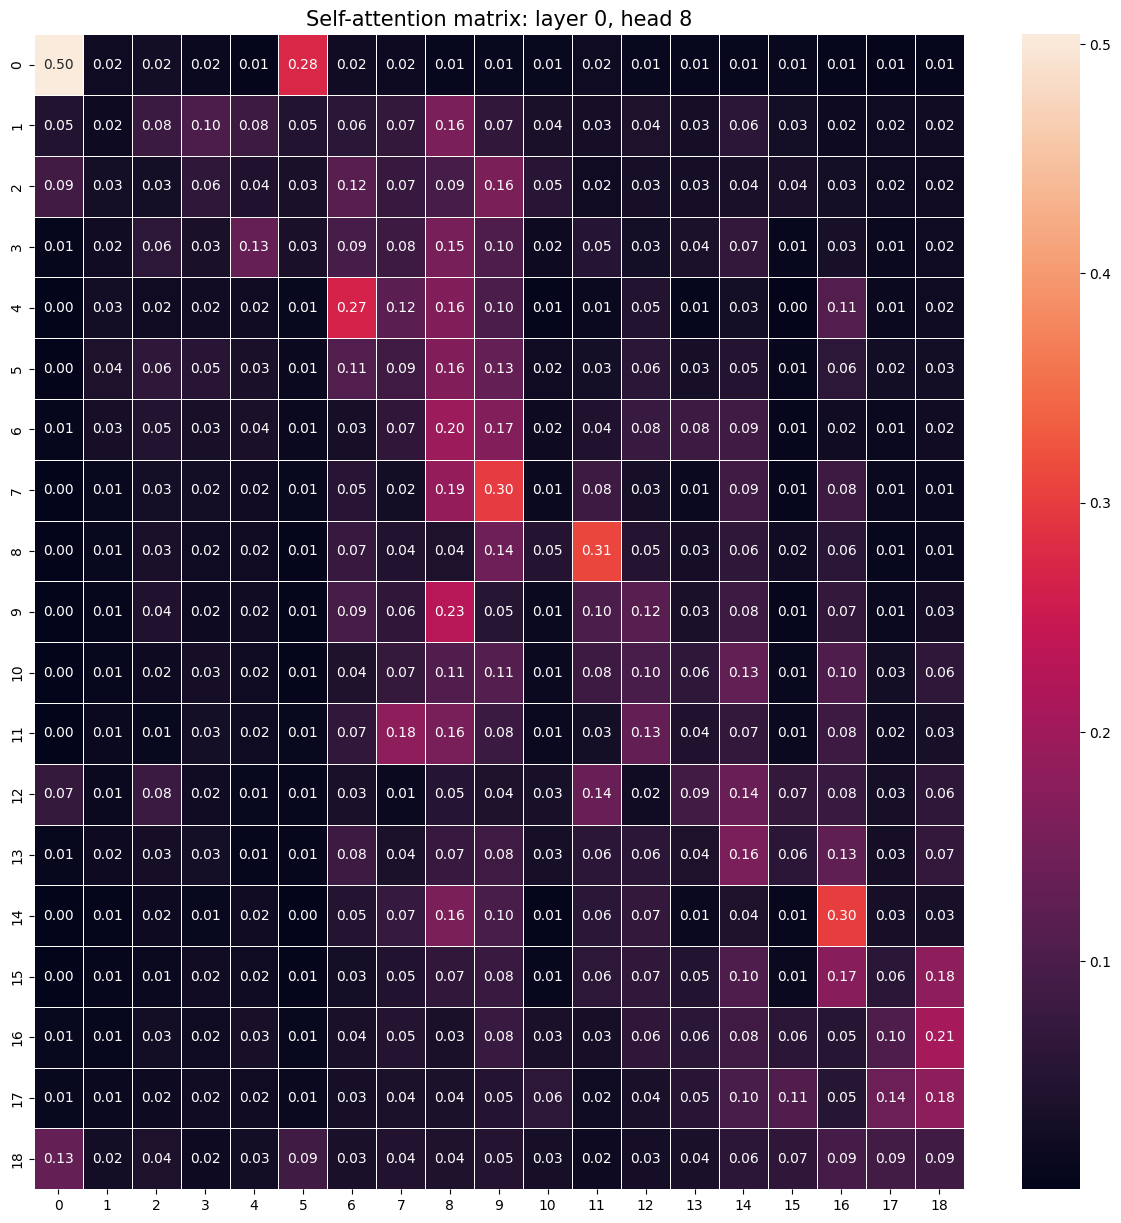

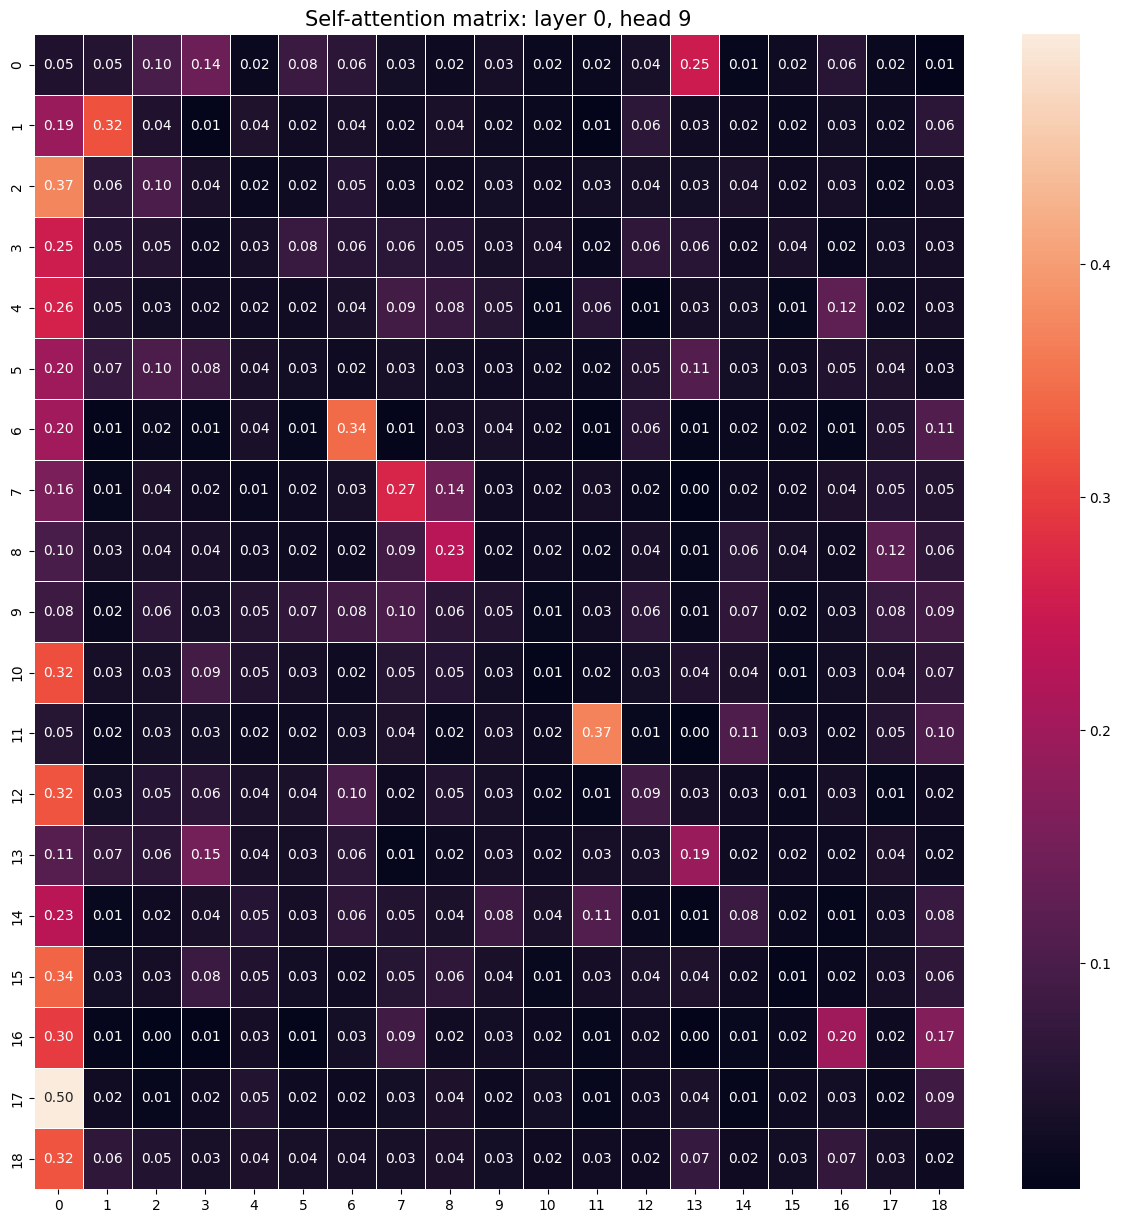

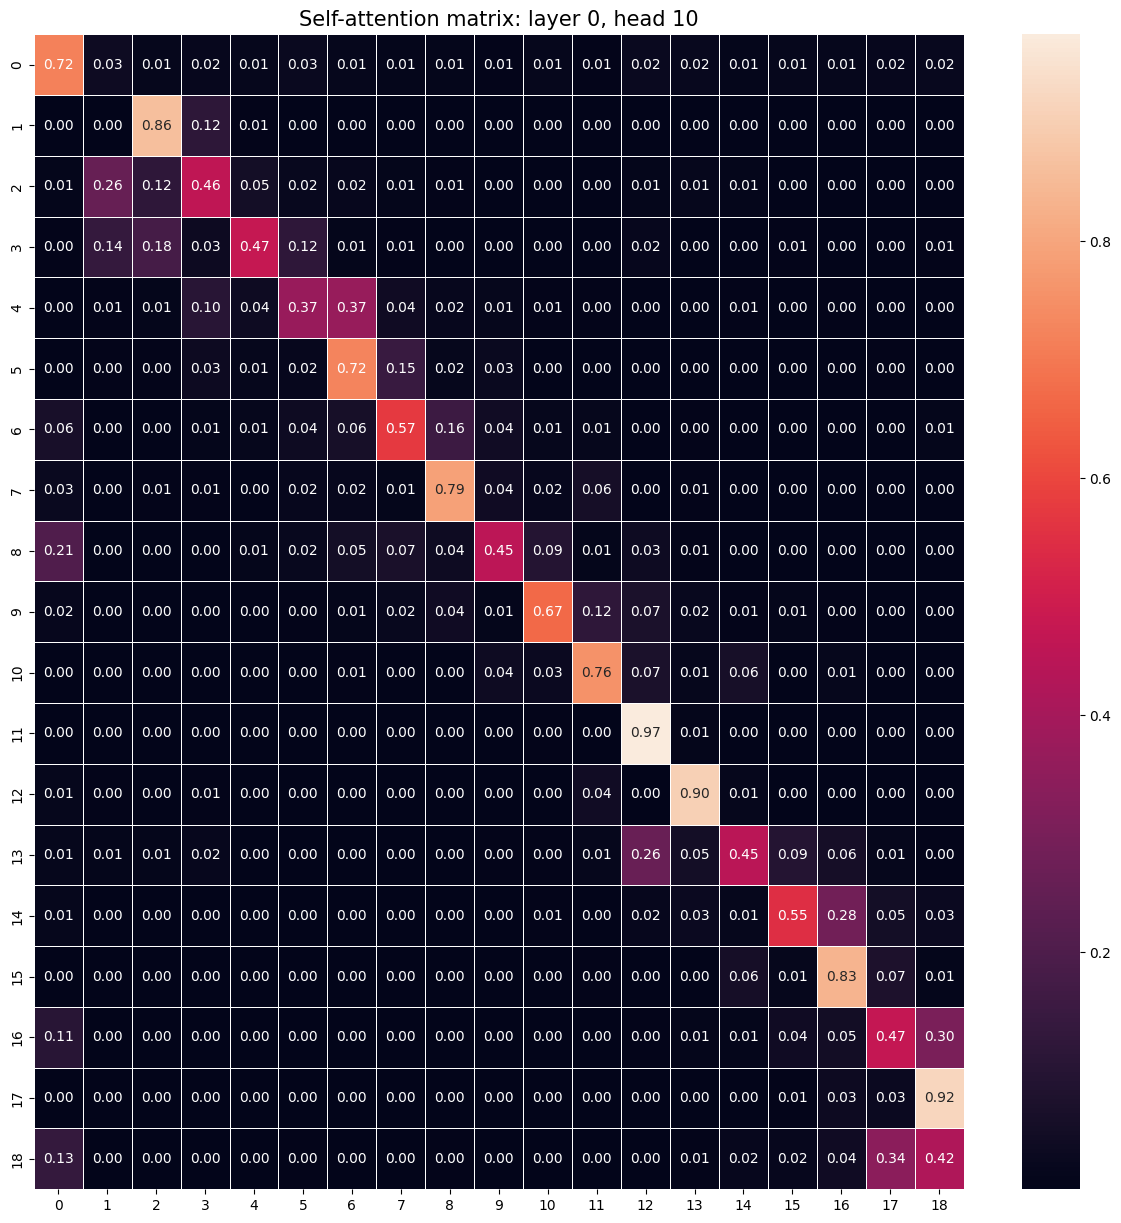

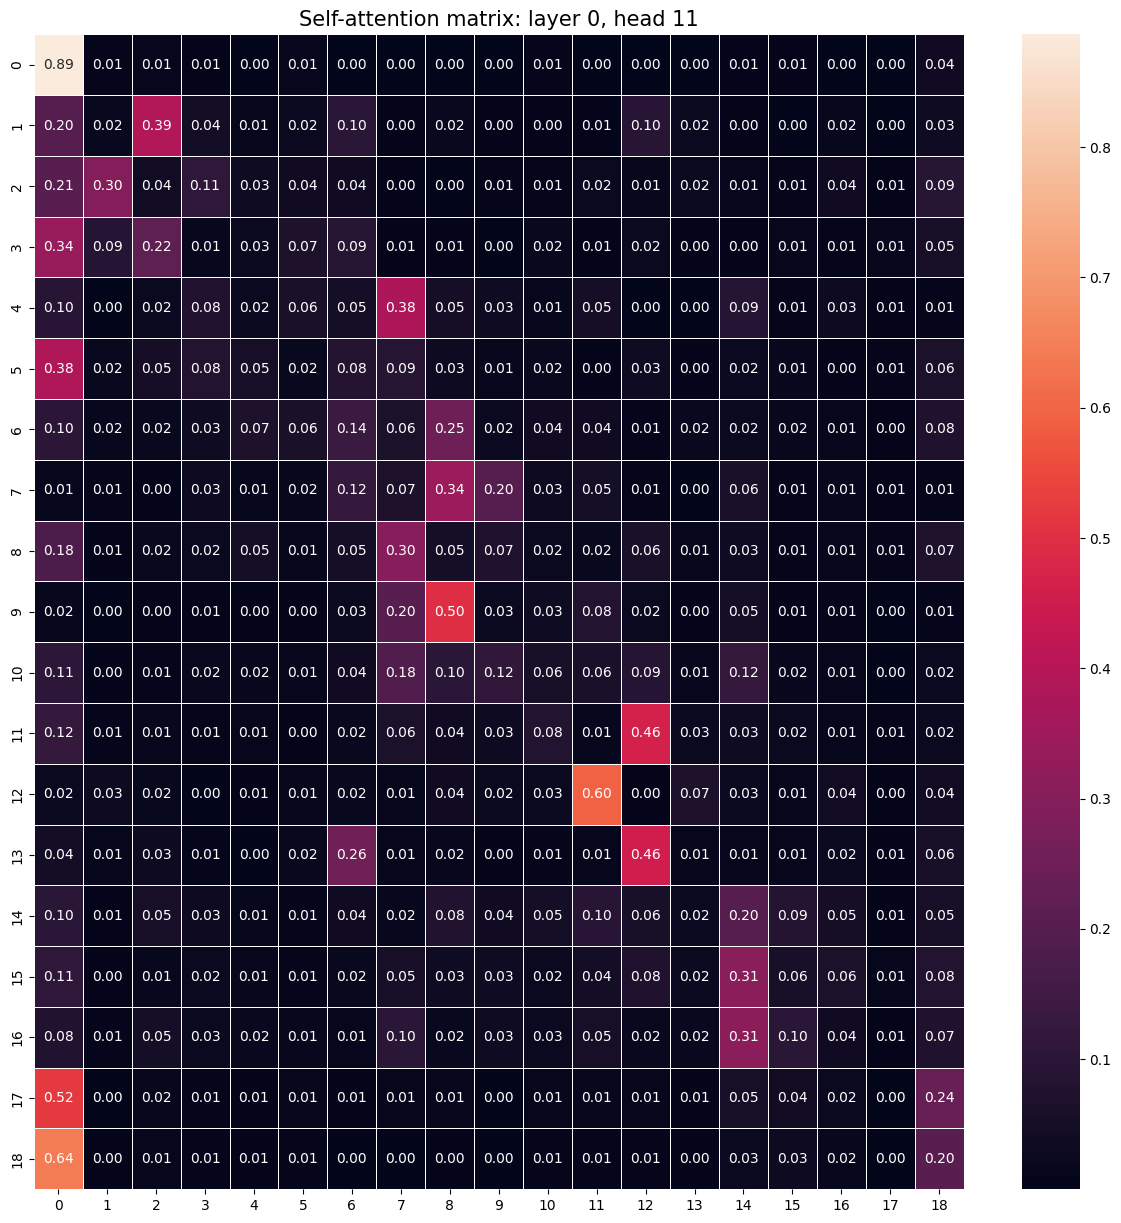

In [15]:
#for layer in range(12):
layer = 0
for head in range(12):
    head_scores = attention_matrix[layer][0][head].cpu().detach().numpy() # First head
    plt.figure(figsize=(15, 15))
    sns.heatmap(
        head_scores,
        linewidth=0.5,
        #xticklabels=labels,
        #yticklabels=labels,
        annot=True,
        fmt='.2f',
    )
    plt.title(f'Self-attention matrix: layer {layer}, head {head}', fontsize=15)
    plt.show()